# Introduction to Natural Language Processing with fastText

Natural Language Processing (NLP) is one of the hottest areas in machine learning. Its global purpose is to understand language the way humans do. [NLP subareas](https://en.wikipedia.org/wiki/Natural_language_processing) include machine translation, text classification, speech recognition, sentiment analysis, question answering, text-to-speech, etc. 

As in most areas of Machine Learning, NLP accuracy has improved considerably thanks to deep learning. Just to highlight the most recent and impressive achievement, in October 2016 [Microsoft Research reached human parity in speech recognition](http://blogs.microsoft.com/next/2016/10/18/historic-achievement-microsoft-researchers-reach-human-parity-conversational-speech-recognition/). For that milestone, they used a combination of Convolutional Neural Networks and LSTM networks. 

However, not all machine learning is deep learning, and in this notebook I would like to highlight a great example. In the summer of 2016, two interesting NLP papers were published by Facebook Research, [Bojanowski et al., 2016](https://arxiv.org/abs/1607.04606) and [Joulin et al., 2016](https://arxiv.org/abs/1607.01759). The first one proposed a new method for word embedding and the second one a method for text classification. The authors also opensourced a C++ library with the implementation of these methods, [fastText](https://github.com/facebookresearch/fastText), that rapidly attracted a lot of interest.  

The reason for this interest is that fastText obtains an accuracy in text classification almost as good as the state of the art in deep learning, but it is several orders of magnitude faster. In their paper, the authors compare the accuracy and computation time of several datasets with deep nets. As an example, in the Amazon Polarity dataset, fastText achieves an accuracy of 94.6% in 10s. In the same dataset, the crepe CNN model of [Zhang and LeCun, 2016](https://arxiv.org/abs/1509.01626) achieves 94.5% in 5 days, while the Very Deep CNN model of [Conneau et al., 2016](https://arxiv.org/abs/1606.01781) achieves 95.7% in 7h. The comparison is not even fair, because while fastText's time is computed with CPUs, the CNN models are computed using Tesla K40 GPUs. 

In this notebook we will discuss how to easily implement several projects using a python wrapper of fastText, [fastText.py](https://github.com/salestock/fastText.py).

In [1]:
#Load all libraries
import os,sys  
import pandas as pd
import numpy as np
import fasttext
try:
    from urllib.request import urlopen     # For Python 3.0 and later
except ImportError:
    from urllib2 import urlopen     # Fall back to Python 2's urllib2
try:
    from html import unescape  # python 3.4+
except ImportError:
    try:
        from html.parser import HTMLParser  # python 3.x (<3.4)
    except ImportError:
        from HTMLParser import HTMLParser  # python 2.x
    unescape = HTMLParser().unescape
from sklearn.manifold import TSNE
%pylab inline

print(sys.version)

Populating the interactive namespace from numpy and matplotlib
3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


## Text classification
The first task will be to perform text classification dataset DBPedia, which can be accessed [here](https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M). The dataset consists of text descriptions of 14 different classes. The training set contains 560,000 reviews and the test contains 70,000. 

In [2]:
# Set dataset path

data_path = ''

#Load train set
train_file = data_path + 'dbpedia_train.csv'
df = pd.read_csv(train_file, header=None, names=['class','name','description'])

#Load test set
test_file = data_path + 'dbpedia_test.csv'
df_test = pd.read_csv(test_file, header=None, names=['class','name','description'])

#Mapping from class number to class name
class_dict={
1:'Company',
2:'EducationalInstitution',
3:'Artist',
4:'Athlete',
5:'OfficeHolder',
6:'MeanOfTransportation',
7:'Building',
8:'NaturalPlace',
9:'Village',
10:'Animal',
11:'Plant',
12:'Album',
13:'Film',
14:'WrittenWork'
}
df['class_name'] = df['class'].map(class_dict)
df.head()

,class,name,description,class_name
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...,Company
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...,Company
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...,Company
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...,Company
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...,Company


In [3]:
#df.describe().transpose()
desc = df.groupby('class')
desc.describe().transpose()

class           1                                                             \
             count unique                                                top   
class_name   40000      1                                            Company   
description  40000  39996   MegaPath Corporation—headquartered in Pleasan...   
name         40000  40000                                            Tsokkos   

class                  2          \
              freq  count unique   
class_name   40000  40000      1   
description      2  40000  39992   
name             1  40000  40000   

class                                                                     3   \
                                                           top   freq  count   
class_name                              EducationalInstitution  40000  40000   
description   Akuressa Training Center of National Youth Se...      2  40000   
name                                           Christ's School      1  40000   

class               ...                                                   12  \
            unique  ...                                                  top   
class_name       1  ...                                                Album   
description  40000  ...     Before Smile Empty Soul became Smile Empty So...   
name         40000  ...            Indispensable: The Best of Michael Franks   

class                  13         \
              freq  count unique   
class_name   40000  40000      1   
description      2  40000  40000   
name             1  40000  40000   

class                                                                     14  \
                                                           top   freq  count   
class_name                                                Film  40000  40000   
description   Koryo Celadon is a 1979 American short docume...      1  40000   
name            Netaji Subhas Chandra Bose: The Forgotten Hero      1  40000   

class                                                                         
            unique                                                top   freq  
class_name       1                                        WrittenWork  40000  
description  39984   Tom Clancy's Net Force Explorers or Net Force...     15  
name         40000                                A Star Called Henry      1  

[3 rows x 56 columns]

The next step is to treat the data. As of today, the python wrapper of fastText doesn't allow dataframes or iterators as inputs to their functions (however, they are [working on it](https://github.com/salestock/fastText.py/issues/78)). We have to create an intermediate file. This intermediate file doesn't have commas, non-ascii characters and everything is lowercase. The changes are based on [this script](https://github.com/facebookresearch/fastText/blob/a88344f6de234bdefd003e9e55512eceedde3ec0/classification-example.sh#L17).

In [4]:
def clean_dataset(dataframe, shuffle=False, encode_ascii=False, clean_strings = False, label_prefix='__label__'):
    # Transform train file
    df = dataframe[['name','description']].apply(lambda x: x.str.replace(',',' '))
    df['class'] = label_prefix + dataframe['class'].astype(str) + ' '
    if clean_strings:
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('"',''))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('\'',' \' '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('.',' . '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('(',' ( '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace(')',' ) '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('!',' ! '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('?',' ? '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace(':',' '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace(';',' '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.lower())
    if shuffle:
        df.sample(frac=1).reset_index(drop=True)
    if encode_ascii :
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8'))
    df['name'] = ' ' + df['name'] + ' '
    df['description'] = ' ' + df['description'] + ' '
    return df

In [5]:
%%time
# Transform datasets
df_train_clean = clean_dataset(df, True, False)
df_test_clean = clean_dataset(df_test, False, False)

# Write files to disk
train_file_clean = data_path + 'dbpedia.train'
df_train_clean.to_csv(train_file_clean, header=None, index=False, columns=['class','name','description'] )

test_file_clean = data_path + 'dbpedia.test'
df_test_clean.to_csv(test_file_clean, header=None, index=False, columns=['class','name','description'] )

CPU times: user 9.75 s, sys: 744 ms, total: 10.5 s
Wall time: 10.7 s


Once the dataset is cleaned, the next step is to train the classifier. 

In [6]:
%%time
# Train a classifier
output_file = data_path + 'dp_model'
classifier = fasttext.supervised(train_file_clean, output_file, label_prefix='__label__')

CPU times: user 1min 20s, sys: 1.3 s, total: 1min 21s
Wall time: 11.8 s


Once the model is trained, we can test its accuracy. We can obtain the [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) of the model. High precision means that an algorithm returned substantially more relevant results than irrelevant ones, while high recall means that an algorithm returned most of the relevant results.

In [7]:
%%time
# Evaluate classifier
result = classifier.test(test_file_clean)
print('P@1:', result.precision)
print('R@1:', result.recall)
print ('Number of examples:', result.nexamples)

P@1: 0.9797857142857143
R@1: 0.9797857142857143
Number of examples: 70000
CPU times: user 564 ms, sys: 0 ns, total: 564 ms
Wall time: 562 ms


The next step is to check how the model works with real sentences.

In [8]:
sentence1 = ['Picasso was a famous painter born in Malaga, Spain. He revolutionized the art in the 20th century.']
labels1 = classifier.predict(sentence1)
class1 = int(labels1[0][0])
print("Sentence: ", sentence1[0])
print("Label: %d; label name: %s" %(class1, class_dict[class1]))

sentence2 = ['One of my favourite tennis players in the world is Rafa Nadal.']
labels2 = classifier.predict_proba(sentence2)
class2, prob2 = labels2[0][0] # it returns class2 as string
print("Sentence: ", sentence2[0])
print("Label: %s; label name: %s; certainty: %f" %(class2, class_dict[int(class2)], prob2))

sentence3 = ['Say what one more time, I dare you, I double-dare you motherfucker!']
number_responses = 3
labels3 = classifier.predict_proba(sentence3, k=number_responses)
print("Sentence: ", sentence3[0])
for l in range(number_responses):
    class3, prob3 = labels3[0][l]
    print("Label: %s; label name: %s; certainty: %f" %(class3, class_dict[int(class3)], prob3))


Sentence:  Picasso was a famous painter born in Malaga, Spain. He revolutionized the art in the 20th century.
Label: 3; label name: Artist
Sentence:  One of my favourite tennis players in the world is Rafa Nadal.
Label: 4; label name: Athlete; certainty: 0.904297
Sentence:  Say what one more time, I dare you, I double-dare you motherfucker!
Label: 12; label name: Album; certainty: 0.287109
Label: 14; label name: WrittenWork; certainty: 0.246094
Label: 1; label name: Company; certainty: 0.240234


The model predicts sentence 1 as `Artist`, which is correct. Sentence 2 is also predicted correctly. This time we used the function `predict_proba` that returns the certainty of the prediction as a probability. Finally, sentence 3 was not correctly classified. The correct label would be `Film`, since the sentence is from a famous scene of a very good film. If by any chance, you don't know [what I'm talking about](https://www.youtube.com/watch?v=xwT60UbOZnI), well, please put your priorities in order. Stop reading this notebook, go to see Pulp Fiction, and then come back to keep learning NLP :-)

## Sentiment Analysis
Sentiment analysis is one of the most important use cases in text classification. The objective is to classify a piece of text into positive, negative and, in some cases, neutral. This is extensively used by brands to understand the perception their customers have on their products. Sentiment analysis can influence marketing campaigns, generate leads, plan product development or improve customer service.  

In our notebook, we will use the Amazon polarity dataset, which contains 3.6 million reviews in the train set and 400,000 reviews in the test set. The reviews are positive or negative. The dataset can be found [here](https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M). 

The first step is to prepare the dataset for the algorithm format.

In [9]:
%%time
#Load train set
train_file = data_path + 'amazon_review_polarity_train.csv'
df_sentiment_train = pd.read_csv(train_file, header=None, names=['class','name','description'])

#Load test set
test_file = data_path + 'amazon_review_polarity_test.csv'
df_sentiment_test = pd.read_csv(test_file, header=None, names=['class','name','description'])

# Transform datasets
df_train_clean = clean_dataset(df_sentiment_train, True, False)
df_test_clean = clean_dataset(df_sentiment_test, False, False)

# Write files to disk
train_file_clean = data_path + 'amazon.train'
df_train_clean.to_csv(train_file_clean, header=None, index=False, columns=['class','name','description'] )

test_file_clean = data_path + 'amazon.test'
df_test_clean.to_csv(test_file_clean, header=None, index=False, columns=['class','name','description'] )

CPU times: user 1min 36s, sys: 7.23 s, total: 1min 43s
Wall time: 3min 19s


Once we have the data, let's train the classifier. This time instead of the default parameters we are going to use those used in the [fastText paper](https://arxiv.org/abs/1607.01759).

In [10]:
%%time
# Parameters
dim=10
lr=0.1
epoch=5
min_count=1
word_ngrams=2
bucket=10000000
thread=12
label_prefix='__label__'

# Train a classifier
output_file = data_path + 'amazon_model'
classifier = fasttext.supervised(train_file_clean, output_file, dim=dim, lr=lr, epoch=epoch,
                                 min_count=min_count, word_ngrams=word_ngrams, bucket=bucket,
                                 thread=thread, label_prefix=label_prefix)

CPU times: user 8min, sys: 15.1 s, total: 8min 15s
Wall time: 1min 10s


Now let's evaluate the results

In [11]:
%%time
# Evaluate classifier
result = classifier.test(test_file_clean)
print('P@1:', result.precision)
print('R@1:', result.recall)
print ('Number of examples:', result.nexamples)

P@1: 0.9418725
R@1: 0.9418725
Number of examples: 400000
CPU times: user 5.27 s, sys: 80 ms, total: 5.35 s
Wall time: 5.34 s


Finally, let's evaluate some sentences

In [12]:
class_dict={
    1:"Negative",
    2:"Positive"
}

sentence1 = ["The product design is nice but it's working as expected"]
labels1 = classifier.predict_proba(sentence1)
class1, prob1 = labels1[0][0] # it returns class as string
print("Sentence: ", sentence1[0])
print("Label: %s; label name: %s; certainty: %f" %(class1, class_dict[int(class1)], prob1))

sentence2 = ["I bought the product a month ago and it was working correctly. But now is not working great"]
labels2 = classifier.predict_proba(sentence2)
class2, prob2 = labels2[0][0] # it returns class as string
print("Sentence: ", sentence2[0])
print("Label: %s; label name: %s; certainty: %f" %(class2, class_dict[int(class2)], prob2))

Sentence:  The product design is nice but it's working as expected
Label: 2; label name: Positive; certainty: 0.992187
Sentence:  I bought the product a month ago and it was working correctly. But now is not working great
Label: 1; label name: Negative; certainty: 0.917969


We can use a tweet as the text input. Twitter has a [REST API](https://dev.twitter.com/rest/public) that allows you to interact with all their data. However, everything from that API requires authentication (an example can be found in this [Twitter bot](https://github.com/miguelgfierro/twitter_bot) I made). Instead, we can parse the title of the tweet url, which contains the text of the tweet.

In [13]:
# Get twitter data
url = "https://twitter.com/miguelgfierro/status/805827479139192832"
response = urlopen(url).read()
title = str(response).split('<title>')[1].split('</title>')[0]
print(title)

# Format tweet
tweet = unescape(title)
print(tweet)

# Classify tweet
label_tweet = classifier.predict_proba([tweet])
class_tweet, prob_tweet = label_tweet[0][0]
print("Label: %s; label name: %s; certainty: %f" %(class_tweet, class_dict[int(class_tweet)], prob_tweet))

Miguel G-Fierro on Twitter: &quot;Today at @Microsoft we had a demo of the hololens. It is one of the most spectacular things I&#39;ve seen in my life&quot;
Miguel G-Fierro on Twitter: "Today at @Microsoft we had a demo of the hololens. It is one of the most spectacular things I've seen in my life"
Label: 2; label name: Positive; certainty: 0.998047


## Word representations
We can also use fastText to learn word vectors. This is a way to represent words in a multidimensional space, where each word is represented as a vector. Similar words will be clustered in a specific region of this multidimensional space. 

As an example we are going to download the English Wikipedia 9 dataset: [enwik9](http://mattmahoney.net/dc/enwik9.zip). The data is UTF-8 encoded XML consisting primarily of English text. enwik9 contains 243,426 article titles, of which 85,560 are #REDIRECT to fix broken links, and the rest are regular articles.  

We can use the script `wikifil.pl` by [Matt Mahoney](http://mattmahoney.net/dc/textdata.html) to clean the data. This script filters Wikipedia XML dumps to "clean" text consisting only of lowercase letters (a-z, converted from A-Z), and spaces (never consecutive).  All other characters are converted to spaces.  Only text which normally appears in the web browser is displayed, tables are removed, image captions are preserved, links are converted to normal text and finally digits are spelled out. 

In [14]:
%%time
wiki_dataset_original = data_path + 'enwik9'
wiki_dataset = data_path + 'text9'
if not os.path.isfile(wiki_dataset):
    os.system("perl wikifil.pl " +  wiki_dataset_original + " > " + wiki_dataset)

CPU times: user 4 ms, sys: 64 ms, total: 68 ms
Wall time: 1min 42s


Let's compute the Skipgram model of the dataset. We will obtain a vector of 50 dimensions for each word. 

In [15]:
%%time
# Learn the word representation using skipgram model
output_skipgram = data_path + 'skipgram'
if os.path.isfile(output_skipgram + '.bin'):
    skipgram = fasttext.load_model(output_skipgram + '.bin')
else:
    skipgram = fasttext.skipgram(wiki_dataset, output_skipgram, lr=0.02, dim=50, ws=5,
        epoch=1, min_count=5, neg=5, loss='ns', bucket=2000000, minn=3, maxn=6,
        thread=4, t=1e-4, lr_update_rate=100)
print(np.asarray(skipgram['king']))

[ 0.16798063  0.0098041  -0.03984898  1.04978788 -0.18959683  0.85292447
 -0.4180353  -0.40085188 -1.08187306  0.8872596   0.41947821  0.19981055
 -0.13649428 -0.24468173 -1.23089099 -0.1748575  -0.03422425  0.43458366
 -0.36701286  0.0804043   0.31023765  0.16417238  0.54866934 -0.75781947
  0.2767764   0.33512017 -0.01796924 -0.17177744 -0.8444469   0.28967109
  0.18059613 -0.70702893  0.42970082  0.05584288 -0.39817047  0.16206688
  0.73674601 -0.08298894  0.16093367  0.36577964 -0.71077859 -0.04718487
 -0.22060201 -0.63146096 -0.58351386 -0.96920103  0.37770718 -0.17785279
  0.2812494  -1.24845505]
CPU times: user 13min 1s, sys: 8.76 s, total: 13min 10s
Wall time: 3min 29s


Since each word is represented in a multidimensional space, we can compute the similarity between words. In that space, the difference between king and queen will be smaller than between king and woman. Makes sense, right? At the same time, the difference between man and woman will be smaller than king and woman. 

With word representations, we are able to map from words to numerical values. What we are doing in fact is to featurize the words. The feautures can be used in different algorithms to learn the meaning of a text.

In [16]:
print("Number of words in the model: ", len(skipgram.words))

# Get the vector of some word
Droyals = np.sqrt(pow(np.asarray(skipgram['king']) - np.asarray(skipgram['queen']), 2)).sum()
print(Droyals)
Dpeople = np.sqrt(pow(np.asarray(skipgram['king']) - np.asarray(skipgram['woman']), 2)).sum()
print(Dpeople)
Dpeople2 = np.sqrt(pow(np.asarray(skipgram['man']) - np.asarray(skipgram['woman']), 2)).sum()
print(Dpeople2)

Number of words in the model:  218316
12.5879589794
20.1630534893
11.2704082606


## Word space visualization

Once we have the vectorial word representation, where each word is located in a 50 dimensional space, it would be great if we could visualize the words in a reduced space.

For that we will use t-Distributed Stochastic Neighbor Embedding (t-SNE) from [van der Mateen and Hinton (2008)](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf). t-SNE is a dimensionality reduction method that is particularly well suited for the visualization of high-dimensional datasets. The idea is to compute the probability distribution of pairs of high dimensional objects in such a way that similar objects have high probability of being clustered together and disimilar objects have low probability of being clustered together. Afterwards, the algorithm projects these probabilities in the low dimensional space and optimizes the distance with respect to the object's location in that space. Therefore, at the end of the optimization, similar objects are close in the low dimensional space. 

First, we must define the words that we are going to analyze out of the complete corpus,  that contains more than 200,000 objects. We have chosen 10 words related to people and 10 words related to animals. 

Once we select the words to analize, we are going to get the word vectors of these words.

In [17]:
print(len(skipgram.words))
targets = ['man','woman','king','queen','brother','sister','father','mother','grandfather','grandmother',
           'cat','dog','bird','squirrel','horse','pig','dove','wolf','kitten','puppy']
classes = [1,1,1,1,1,1,1,1,1,1,
           2,2,2,2,2,2,2,2,2,2]

218316


In [18]:
X_target=[]
for w in targets:
    X_target.append(skipgram[w])
X_target = np.asarray(X_target)

The next step is to select a subset of the dataset, because computing more than 200.000 objects is too expensive.

In [19]:
word_list = list(skipgram.words)[:10000]
X_subset=[]
for w in word_list:
    X_subset.append(skipgram[w])
X_subset = np.asarray(X_subset)

We add both datasets together.

In [20]:
X_target = np.concatenate((X_subset, X_target))
print(X_target.shape)

(10020, 50)


Next, we compute the t-SNE algorithm.

In [21]:
%%time
X_tsne = TSNE(n_components=2, perplexity=40, init='pca', method='exact',
                  random_state=0, n_iter=200, verbose=2).fit_transform(X_target)
print(X_tsne.shape)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 10020
[t-SNE] Computed conditional probabilities for sample 2000 / 10020
[t-SNE] Computed conditional probabilities for sample 3000 / 10020
[t-SNE] Computed conditional probabilities for sample 4000 / 10020
[t-SNE] Computed conditional probabilities for sample 5000 / 10020
[t-SNE] Computed conditional probabilities for sample 6000 / 10020
[t-SNE] Computed conditional probabilities for sample 7000 / 10020
[t-SNE] Computed conditional probabilities for sample 8000 / 10020
[t-SNE] Computed conditional probabilities for sample 9000 / 10020
[t-SNE] Computed conditional probabilities for sample 10000 / 10020
[t-SNE] Computed conditional probabilities for sample 10020 / 10020
[t-SNE] Mean sigma: 0.478634
[t-SNE] Iteration 25: error = 23.4018832, gradient norm = 0.0507323
[t-SNE] Iteration 50: error = 23.6799925, gradient norm = 0.0496832
[t-SNE] Iteration 75: error = 22.9733908, gradient norm 

If we draw all the words in the same plot, it would be impossible to understand anything, so we are only going to represent the target words.

In [22]:
X_tsne_target = X_tsne[-20:,:]
print(X_tsne_target.shape)

(20, 2)


In [23]:
def plot_words(X, labels, classes=None, xlimits=None, ylimits=None):
    fig = figure(figsize=(6, 6))
    if xlimits is not None:
        xlim(xlimits)
    if ylimits is not None:
        ylim(ylimits)
    scatter(X[:, 0], X[:, 1], c=classes)
    for i, txt in enumerate(labels):
        annotate(txt, (X[i, 0], X[i, 1]))

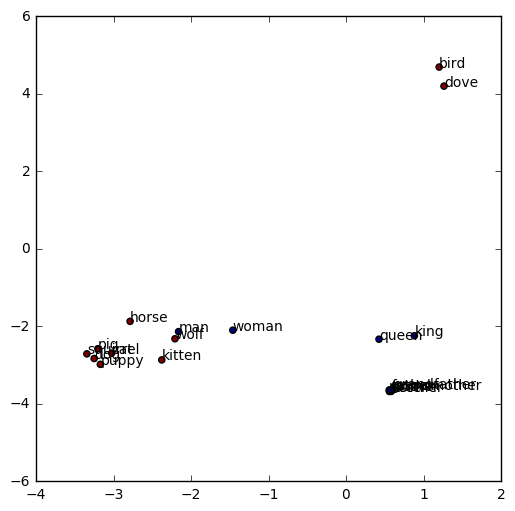

In [24]:
plot_words(X_tsne_target, targets, classes=classes)

In the previous plot we can see the target words represented in a 2 dimensional space. As you can see, words related to animals are clustered together. The words related to people form a couple of clusters. We can take a zoom to the cluster to the bottom right to see what words are clustered together

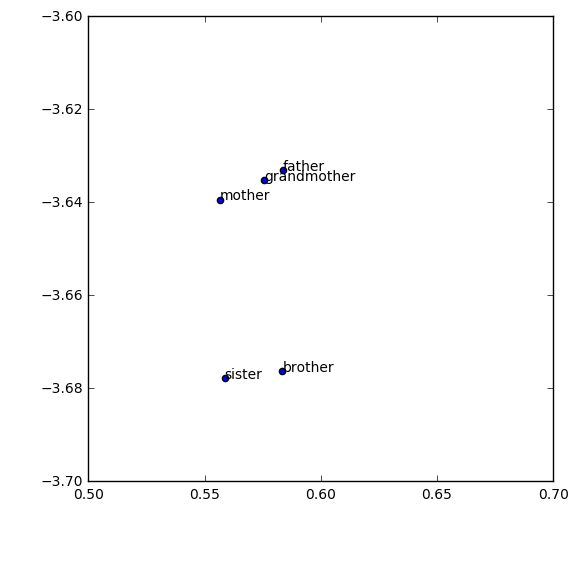

In [27]:
plot_words(X_tsne_target, targets, xlimits=[0.5,0.7], ylimits=[-3.7,-3.6])

## Conclusion 
In this notebook we have shown how to classify text, perform sentiment analysis, create word representations and visualize these representations in a XY plot. fastText is an easy to use framework to work with these NLP problems. Its most remarkable feature is its computation speed, that allows to train models very quick mantaining a high level of accuracy in comparison to other methods like [deep learning](https://arxiv.org/abs/1509.01626). 
